[*********************100%***********************]  1 of 1 completed


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.5220 - loss: 0.6830 - val_accuracy: 0.7037 - val_loss: 0.6152
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7008 - loss: 0.6128 - val_accuracy: 0.7037 - val_loss: 0.6295
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6935 - loss: 0.6422 - val_accuracy: 0.7037 - val_loss: 0.6046
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6935 - loss: 0.6159 - val_accuracy: 0.7037 - val_loss: 0.5990
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7091 - loss: 0.5974 - val_accuracy: 0.7037 - val_loss: 0.5969
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7237 - loss: 0.5762 - val_accuracy: 0.7037 - val_loss: 0.5742
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7071 - loss: 0.5687 - val_accuracy: 0.7037 - val_loss: 0.5469
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7029 - loss: 0.5393 - val_accuracy: 0.7407 - val_loss: 0.4934


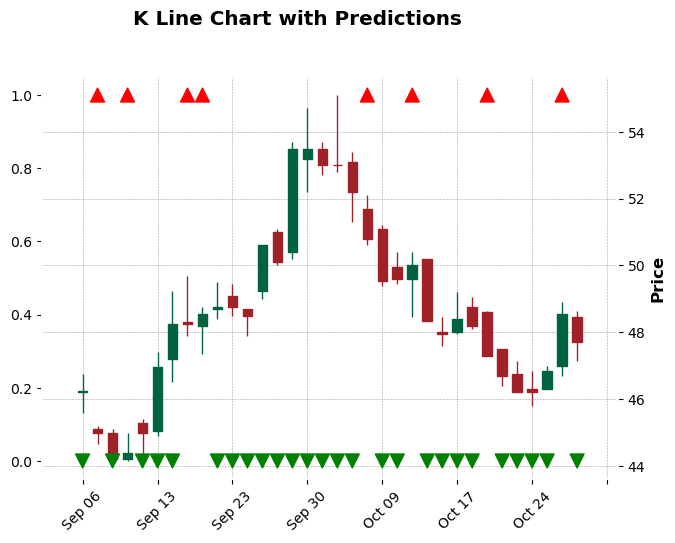

In [56]:
import numpy as np
import pandas as pd
import yfinance as yf
import mplfinance as mpf
import tensorflow as tf
from keras import layers, models
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
# 參數設定
N = 20  # K線圖的天數
IMG_SIZE = 64  # 圖像大小
EPOCHS = 10  # 訓練回合數
BATCH_SIZE = 32  # 批次大小

# 1. 下載數據
data = yf.download("1301.TW", start="2024-01-01", end="2024-10-30")

# 修改column name
data.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# 2. 計算5日和10日均線
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA10'] = data['Close'].rolling(window=10).mean()

# 3. 標註漲跌
data['Label'] = np.where(data['MA5'] > data['MA10'], 1, 0)
data.dropna(inplace=True)

# 4. 生成 K 線圖並轉成矩陣，漲為紅色，跌為綠色
def create_candlestick_image(data, start_idx, img_size=IMG_SIZE):
    df = data.iloc[start_idx:start_idx + N]
    taiwan_style = mpf.make_mpf_style(
    base_mpf_style='charles',  # 可以選擇一個基礎樣式
    marketcolors=mpf.make_marketcolors(
        up='r',  # 上漲用紅色
        down='g',  # 下跌用綠色
        edge='inherit',  # 繼承顏色
        wick='inherit',  # 繼承顏色
        volume='inherit'  # 繼承顏色
        )
    )
    fig, ax = mpf.plot(df, type='candle', style=taiwan_style, axisoff=True, returnfig=True)
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer.buffer_rgba())
    img = Image.fromarray(img).resize((img_size, img_size)).convert('L')  # 轉為灰階
    plt.close(fig)
    return np.array(img) / 255.0

# 5. 構建數據集
images = []
labels = []
for i in range(len(data) - N):
    images.append(create_candlestick_image(data, i))
    labels.append(data['Label'].iloc[i + N])

images = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # 調整形狀
labels = np.array(labels)

# # 6. 分割訓練和測試集
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# 7. CNN 模型
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 8. 訓練模型
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

# 9. 評估模型
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

# 10. 預測
predictions = (model.predict(X_test) > 0.5).astype("int32")

# 以K線圖顯示預測結果
# 2. 定義顯示預測的顏色（紅色為預測漲，綠色為預測跌）
colors = ['r' if p == 1 else 'g' for p in predictions.flatten()]
marker = ['^' if p == 1 else 'v' for p in predictions.flatten()]

# 3. 繪製K線圖，並顯示預測結果
add_plot = [mpf.make_addplot(predictions.flatten(), type='scatter', color=colors, marker=marker, markersize=100)]

mpf.plot(data[-len(predictions):], type='candle', style='charles', addplot=add_plot,
        title="K Line Chart with Predictions", ylabel="Price")
